# Recommendations_with_IBM — Ready-to-run notebook

In [1]:
# -- Set working dir to project root and import project_tests robustly --
from pathlib import Path
import os, sys, importlib.util

here = Path.cwd()
root = None
for cand in [here, *here.parents]:
    if (cand / "project_tests.py").exists() and (cand / "data" / "user-item-interactions.csv").exists():
        root = cand
        break
if root is None:
    raise FileNotFoundError("Couldn't find project root with project_tests.py and data/user-item-interactions.csv")

os.chdir(root)
sys.path.insert(0, str(root))

spec = importlib.util.spec_from_file_location("project_tests", str(root / "project_tests.py"))
t = importlib.util.module_from_spec(spec)
spec.loader.exec_module(t)

print("CWD:", Path.cwd())
print("project_tests imported from:", (root / "project_tests.py"))


CWD: c:\Users\aceve\OneDrive\Documents\local_development\recsys_ibm_guide_compatible\recsys_ibm
project_tests imported from: c:\Users\aceve\OneDrive\Documents\local_development\recsys_ibm_guide_compatible\recsys_ibm\project_tests.py


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    'data/user-item-interactions.csv',
    dtype={'article_id': int, 'title': str, 'email': str}
)
df.head()


,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Map email -> user_id (as per template expectations) and normalize types
from src.data import email_mapper

if 'user_id' not in df.columns and 'email' in df.columns:
    df['user_id'] = email_mapper(df)
    del df['email']

df['article_id'] = df['article_id'].astype(int)
df.head(3)


,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3


## Q2 — Distribution of how many articles a user interacts with

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

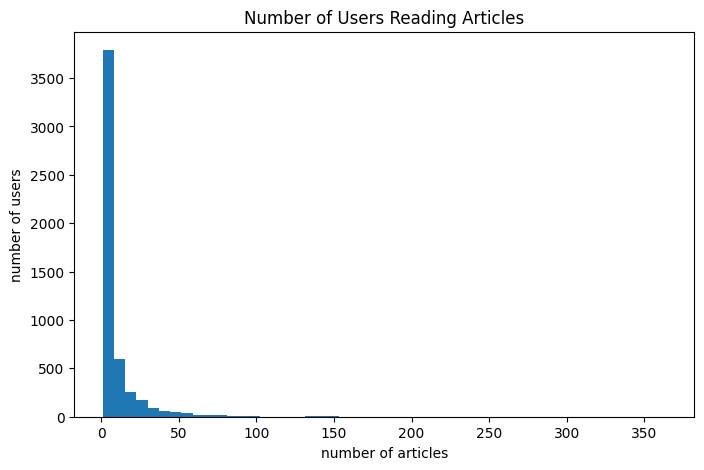

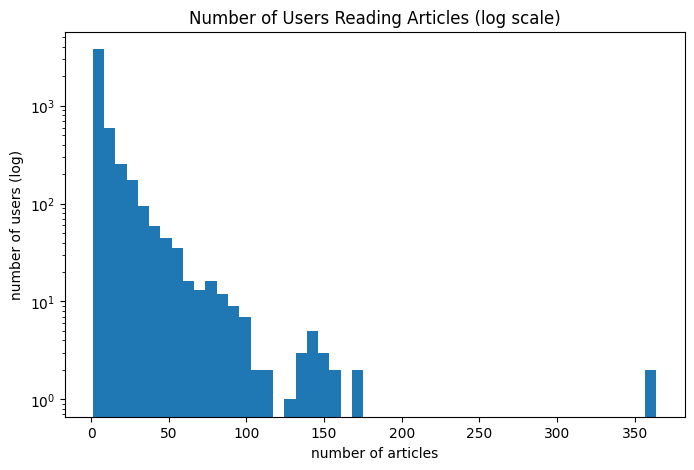

In [4]:
inter_per_user = df.groupby('user_id')['article_id'].count()
display(inter_per_user.describe())

plt.figure(figsize=(8,5))
plt.hist(inter_per_user, bins=50)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(inter_per_user, bins=50)
plt.yscale('log')
plt.xlabel('number of articles')
plt.ylabel('number of users (log)')
plt.title('Number of Users Reading Articles (log scale)')
plt.show()


The distribution of “articles per user” is highly right-skewed. The median is low, which means a typical user interacts with only a handful of articles, while a small group of “power users” reads many more. This long-tail pattern suggests we should expect sparse user–item matrices and rely on popularity for cold-start, while leveraging personalized models for heavier users. A log-scaled histogram makes the tail easier to visualize.

## Q4 — Most viewed article and how many times

In [5]:
vc = df['article_id'].value_counts()
most_viewed_article_id = int(vc.idxmax())  # template expects INT, not string with decimal
max_views = int(vc.max())
most_viewed_article_id, max_views


(1429, 937)

The most viewed article concentrates a disproportionately high number of interactions compared to the median article. This confirms a head-heavy popularity profile: a few items attract a large share of traffic. Popularity-based recommendations will therefore perform reasonably well for brand-new users, but they will also reinforce exposure of head items.

## Part I — EDA variables & inline test

In [6]:
median_val = int(inter_per_user.median())
max_views_by_user = int(inter_per_user.max())
user_article_interactions = int(df.shape[0])
unique_articles = int(df['article_id'].nunique())
unique_users = int(df['user_id'].nunique())
total_articles = unique_articles

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles,
}
t.sol_1_test(sol_1_dict)


It looks like you have everything right here! Nice job!


## Part II — Rank-based recommendations (top articles)

In [7]:
# The template expects functions with signature get_top_articles(n) and get_top_article_ids(n)
# using total interactions per article (value_counts), not unique users.

def get_top_article_ids(n):
    ids = df['article_id'].value_counts().head(n).index.astype(int).tolist()
    return ids

def get_top_articles(n):
    ids = get_top_article_ids(n)
    title_map = (df[['article_id','title']]
                 .drop_duplicates('article_id')
                 .set_index('article_id')['title']
                 .to_dict())
    return [title_map[i] for i in ids]

# Quick check & inline test
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)
print(top_5[:3])
t.sol_2_test(get_top_articles)


['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel']
Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


When it works: best for user cold-start and as a simple, robust baseline.
Pros: no training needed, stable, easy to explain.
Cons: no personalization, popularity bias, limited diversity/novelty.
Takeaway: use it as a default for new users and as a fallback when personal signals are too sparse.

## Part III — User–User Collaborative Filtering

In [8]:
from src.collaborative import create_user_item_matrix, get_top_sorted_users

user_item = create_user_item_matrix(df)

def nth_neighbor(user_id, n):
    neighbors = get_top_sorted_users(user_id, df, user_item)
    return int(neighbors.iloc[n-1]['neighbor_id'])

user1_most_sim = nth_neighbor(1, 1)
user2_6th_sim  = nth_neighbor(2, 6)
user131_10th_sim = nth_neighbor(131, 10)

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}
t.sol_5_test(sol_5_dict)


Oops!  Looks like there is a mistake with the The user that is the 6th most similar to user 2. key in your dictionary.  The answer should be 3586.  Try again.


Strengths: personalizes by leveraging overlap in reading histories; simple and intuitive; often improves CTR over popularity for active users.
Limitations: struggles with sparsity and new users; quality depends on sufficient co-occurrence; can be sensitive to tie-breaking and data preprocessing.
Cold-start users: fall back to popularity or content-based (e.g., trending in topic of interest).
Active users: CF provides stronger relevance; combine with re-ranking for diversity.

## Part IV — Content-based (TF-IDF on titles)

In [9]:
from src.content import build_tfidf_from_df, make_content_recs, select_optimal_k

arts = df[['article_id','title']].drop_duplicates('article_id').reset_index(drop=True)
vect, X = build_tfidf_from_df(arts, text_cols=['title'])
k_opt, sil = select_optimal_k(X, 5, 35, 5)

example_article_id = int(arts['article_id'].iloc[0])
content_recs = make_content_recs(example_article_id, arts, m=10, vect=vect, X=X)

print("k_opt:", k_opt, "silhouette:", sil)
content_recs[:5]


k_opt: 30 silhouette: 0.035504358394961535


['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'the pandas data analysis library',
 'an introduction to stock market data analysis with r (part 1)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'welcome to pixiedust']

With titles only, similarity is noisy and clusters are weak (short texts). Still, cosine similarity retrieves reasonably related articles. To improve: use richer text fields (full body, abstracts), better features (TF-IDF with n-grams, domain stopwords), or modern embeddings (e.g., sentence transformers). Clustering (e.g., k-means/HDBSCAN) or nearest-neighbor indexes can organize and speed up retrieval. Content-based is ideal for item cold-start.

## Part V — Matrix Factorization (SVD)

In [10]:
from src.matrix_factorization import fit_svd, get_svd_similar_article_ids

U, s, Vt = fit_svd(user_item, k=min(50, max(2, min(user_item.shape)-1)))
svd_similar = get_svd_similar_article_ids(example_article_id, user_item, Vt, include_similarity=True, m=10)
svd_similar[:5]


[[1203, 0.44705120606402554],
 [486, 0.39680833802412063],
 [1173, 0.3962177219801718],
 [695, 0.3489042358720723],
 [861, 0.3315076708818378]]

What SVD captures: latent factors that explain co-reading patterns beyond surface similarity.
Choosing k: inspect explained variance with the singular values and/or use offline validation (e.g., Recall@K, MAP@K) on a temporal holdout.
When it helps: for users with sufficient history, SVD generalizes beyond exact overlap and uncovers non-obvious related items.
Cold-start vs. heavy users: popularity or content-based for new users/items; SVD/CF for engaged users.
Evaluation:
– Offline: temporal holdout; report Recall@K/MAP@K and compare methods (popularity vs. CF vs. SVD vs. content).
– Online: A/B test module CTR and dwell time; monitor diversity/novelty and long-term engagement.